# tranmons env
## transmon_cont_quspin.py

In [6]:
'''transmon_cont_quspin.py'''
from quspin.operators import hamiltonian 
from quspin.basis import boson_basis_1d
import numpy as np
from scipy.linalg import expm,svd
from scipy.optimize import minimize
from scqp import solve_SCQP
from utility import *

PI = np.pi

def tensor(arr):
    prod = arr[0]
    for i in range(1,len(arr)):
        prod = np.kron(prod,arr[i])
    return prod

class quspin_duffing_simulator():
    '''
    Input: params
        - ctrl: control parameters in MHz
        - dt: time segment size in us 
        - error:
            + If within [0,1], treat as percentage of parameter's amplitude
            + If larger than 1, treat as an absolute uncertainty in Hz
    '''
    def __init__(self, params):
        L = self.L = params['num_transmon']
        self.num_level = params['num_level']
        self.basis = boson_basis_1d(L=self.L, sps=self.num_level)

        self.ctrl = params['ctrl']
        self.ctrl_noise = params['ctrl_noise']
        self.current_ctrl = {}
        dt = self.dt = params['dt']
        self.coupling_list = [[i,j] for i in range(self.L) for j in range(i+1,self.L)]
        
        # fixed error in Hz
        if self.ctrl_noise:  
            if self.ctrl_noise > 1:
                print(f'-   Noisy control with variance: {self.ctrl_noise/MHz} MHZ')
            else:
                print(f'-   Noisy control with variance: {self.ctrl_noise*100}%')
        else:
            print('-   Noiseless control')

            
        detune_coeff   = [[2*PI*coeff*dt,i]       for i,coeff in zip(range(L),self.ctrl['detune'])]
        anharm_coeff   = [[  PI*coeff*dt,i,i,i,i] for i,coeff in zip(range(L),self.ctrl['anharm'])]
        coupling_coeff = [[2*PI*coeff*dt,*ij]     for ij,coeff in zip(self.coupling_list,self.ctrl['coupling'])]
                
        # print('ctrl:')
        # for key,val in self.ctrl.items():
        #     print(f'\t{key}: \t{val}')
            
        static = [['n',detune_coeff],
                  ['++--',anharm_coeff],
                  ['+-',coupling_coeff],
                  ['-+',coupling_coeff]]
        
        if params['sim_frame_rotation']:
            ham_no_drive = np.flip(hamiltonian(static,[],dtype=np.complex128,basis=self.basis,
                                    check_symm=False,check_herm=False).toarray())
            self.dressed_to_sim = block_diag_transf_mat(ham_no_drive,self.num_level)
        else:
            self.dressed_to_sim = np.eye(self.num_level**self.L)
        # _,self.dressed_to_sim = np.linalg.eigh(ham_no_drive.toarray())

    def get_expmap(self, pulse, t_step):
        expmap, expmap_super = [],[]
        L, dt = self.L, self.dt
        # Perturb control params if specified
        if self.ctrl_noise:
            for param in self.ctrl.keys():
                noise_var = self.ctrl_noise/MHz if self.ctrl_noise >= 1 else self.ctrl_noise*abs(self.ctrl[param])
                self.current_ctrl =  np.random.normal(self.ctrl[param],noise_var)
        else:
            self.current_ctrl = self.ctrl.copy()
            
        # if self.error:
        #     # get error on control params
        #     for param in self.ctrl.keys():
        #         error_var = self.error/MHz if self.error > 1 else self.error*abs(self.ctrl[param])
        #         self.deltas[param] =  np.random.normal(0,error_var)
        #         self.current_ctrl[param] = self.ctrl[param] + self.deltas[param]
        # else:
        #     self.current_ctrl = self.ctrl.copy()
            # print('delta:')
            # for key,val in self.deltas.items():
            #     print(f'\t{key}: \t{val}')
            # print('current ctrl:')
            # for key,val in self.current_ctrl.items():
            #     print(f'\t{key}: \t{val}')
            # update control params
        self.detune_coeff   = [[2*PI*coeff*dt,i]       for i,coeff in zip(range(L),self.current_ctrl['detune'])]
        self.anharm_coeff   = [[  PI*coeff*dt,i,i,i,i] for i,coeff in zip(range(L),self.current_ctrl['anharm'])]
        self.coupling_coeff = [[2*PI*coeff*dt,*ij]     for ij,coeff in zip(self.coupling_list,self.current_ctrl['coupling'])]
            
        # for pulse in actions:
        drive_coeff_p,drive_coeff_m = [],[]
        for i in range(L):
            # D(t)b + D(t).conj()b^dag
            drive_coeff_p.append([(pulse[2*i]-1j*pulse[2*i+1]) * 2*PI*dt*self.current_ctrl['drive'][i],i])
            drive_coeff_m.append([(pulse[2*i]+1j*pulse[2*i+1]) * 2*PI*dt*self.current_ctrl['drive'][i],i])
        static = [['+',drive_coeff_p],
                  ['-',drive_coeff_m],
                  ['n',self.detune_coeff],
                  ['++--',self.anharm_coeff],
                  ['+-',self.coupling_coeff],
                  ['-+',self.coupling_coeff]]
        H = np.flip(hamiltonian(static,[],dtype=np.complex128,basis=self.basis,
                                check_symm=False,check_herm=False).toarray()) 
        expmap = expm(-1j*H)
        # expmap_super = tensor([expmap,expmap.conj()])
        return expmap #,expmap_super       
        
        #     expmap.append(expm(-1j*H))
        #     expmap_super.append(tensor([expmap[-1],expmap[-1].conj()]))
        # expmap = np.array(expmap)
        # expmap_super = np.array(expmap_super)
        # return expmap,expmap_super       
    
    ##OLD STUFFS START##
#     def __init__(self, params):
#         self.L = params['num_transmon']
#         self.num_level = params['num_level']
#         self.basis = boson_basis_1d(L=self.L, sps=self.num_level)

#         self.drive = params['drive']
#         self.detuning =      [[coeff,i]       for i,coeff in zip(range(self.L),params['detuning'])]
#         self.anharmonicity = [[coeff,i,i,i,i] for i,coeff in zip(range(self.L),params['anharmonicity'])]
#         coupling_list =      [[i,j]           for i in range(self.L) for j in range(i+1,self.L)]
#         self.coupling =      [[coeff,*ij]     for ij,coeff in zip(coupling_list,params['coupling'])]
        
#         static = [['n',self.detuning],
#                   ['++--',self.anharmonicity],
#                   ['+-',self.coupling],
#                   ['-+',self.coupling]]
        
#         if params['sim_frame_rotation']:
#             ham_no_drive = np.flip(hamiltonian(static,[],dtype=np.complex128,basis=self.basis,
#                                     check_symm=False,check_herm=False).toarray())
#             self.dressed_to_sim = block_diag_transf_mat(ham_no_drive,self.num_level)
#         else:
#             self.dressed_to_sim = np.eye(self.num_level**self.L)
# #         _,self.dressed_to_sim = np.linalg.eigh(ham_no_drive.toarray())
        
#     def calc_expmap(self, actions):
#         expmap = []
#         expmap_super = []
#         N = self.num_level**self.L
#         N2 = N**2
#         identity = np.eye(N)
#         for pulse in actions:
#             drive_coeff_p = [[ (pulse[2*i]+1j*pulse[2*i+1]) * drive ,i] for i,drive in zip(range(self.L),self.drive)]
#             drive_coeff_m = [[ (pulse[2*i]-1j*pulse[2*i+1]) * drive ,i] for i,drive in zip(range(self.L),self.drive)]
#             print(drive_coeff_m,self.detuning)
#             static = [['+',drive_coeff_p],
#                       ['-',drive_coeff_m],
#                       ['n',self.detuning],
#                       ['++--',self.anharmonicity],
#                       ['+-',self.coupling],
#                       ['-+',self.coupling]]
#             H = np.flip(hamiltonian(static,[],dtype=np.complex128,basis=self.basis,
#                                     check_symm=False,check_herm=False).toarray())  
#             expmap.append(expm(-1j*H))
#             expmap_super.append(tensor([expmap[-1],expmap[-1].conj()]))
#         expmap = np.array(expmap)
#         expmap_super = np.array(expmap_super)
#         return expmap,expmap_super       
    ##OLD STUFFS END##
    
def bloch_args(env,correction):
    '''
    Input: ndarray of shape [num_level^2^N,basis_size]
    Return:
        Bloch representation arguments, i.e. A_ij and b_i
    '''
    num_transmon,num_level = env.sim.L,env.sim.num_level
    evolved_basis,target_basis = correction@env.get_state(),env.target_state

    eps = 5e-8
    if num_level == 2:
        
        if num_transmon == 1:
            A = (evolved_basis.T.conj() @ target_basis+
                 target_basis.T.conj() @ evolved_basis)
            b = np.zeros(len(A))
            c = 0.5
            constraints = None
        else:
            print(f'Worst fidelity is not implemented!')
            raise NotImplementedError

    elif num_level == 3:
        
        if num_transmon == 1:
            # first element is lambda_8
            evolved_pauli,evolved_lam8 = evolved_basis[:,1:],evolved_basis[:,0]
            target_pauli,target_lam8 = target_basis[:,1:],target_basis[:,0]
            c = (1/3) + (evolved_lam8@target_lam8)
            b = (evolved_lam8.conj() @ target_pauli + 
                 target_lam8.conj() @ evolved_pauli)
            A = (evolved_pauli.T.conj() @ target_pauli +
                 target_pauli.T.conj() @ evolved_pauli) + c*np.eye(len(b))
            constraints = None
            
        elif num_transmon == 2:
            # first element is Lambda_0
            evolved_pauli,evolved_lam0 = evolved_basis[:,1:],evolved_basis[:,0]
            target_pauli,target_lam0 = target_basis[:,1:],target_basis[:,0]
            # c = (1/9) + (evolved_lam0@target_lam0)
            # b = (evolved_lam0.conj() @ target_pauli + 
            #      target_lam0.conj()  @ evolved_pauli)
            # A = (evolved_pauli.T.conj() @ target_pauli +
            #      target_pauli.T.conj()  @ evolved_pauli)
            b = (evolved_lam0.conj() @ target_pauli + 
                 target_lam0.conj()  @ evolved_pauli)/16
            A = evolved_lam0.conj()@target_lam0/24*np.eye(len(b)) +\
                (evolved_pauli.T.conj() @ target_pauli +
                 target_pauli.T.conj()  @ evolved_pauli)/16
                 
            constraints = 'useless string'

        else:
            print(f'Worst fidelity is not implemented!')
            raise NotImplementedError
        assert (abs(b.imag)<eps).all()
        assert (abs(A.imag)<eps).all()
        assert (abs(A.real.T-A.real)<eps).all()
        return A.real,b.real,constraints    

def SLSQP_minimize(num_param,const,obj_func,args,jac=None,init_guess=None,bounds=None,cons=()):
    '''
    Use SLSQP method from scipy
    Add two additional runs from random initial guess when obj_fun excess the threshold
    '''
    z0 = np.random.random(num_param) if init_guess is None else init_guess
    options = {'maxiter': 500, 'ftol': 1e-10, 'disp': False, 'eps': 1e-10}
    res = minimize(obj_func,z0,args=args,jac=jac,method='SLSQP',bounds=bounds,options=options,constraints=cons)
    if res.fun+const < 0.99:
        return res.x,res.fun+const
    else:
        xs,fs = [res.x],[res.fun]
        for i in range(2):
            res = minimize(obj_func,np.random.random(num_param),args=args,jac=jac,method='SLSQP',bounds=bounds,options=options,constraints=cons)
            xs.append(res.x)
            fs.append(res.fun)
        return xs[np.argmin(fs)],min(fs)+const
    
def param2ket(z,num_qubit):
    ''' From real parameters to a complex ket'''
    if num_qubit == 1:
        # 2 DOFs: (z,theta) -> psi = sqrt(1-z**2)|0> + z*exp(1j*theta)|1>
        if len(z) == 2:
            psi = np.array([np.sqrt(1-z[0]**2),z[0]*np.exp(1j*z[1])])
        # 3 DOFs: (z0,z1,theta) -> psi = z0|0> + z1*exp(1j*theta)|1>
        elif len(z) == 3:
            psi = z[:2].astype(np.complex128)/np.sqrt(z[:2]@z[:2])
            psi[1] *= np.exp(1j*z[2])
    elif num_qubit == 2:
        # 7 DOFs: (z0,z1,z2,z3,theta1,theta2,theta3)
        if len(z) == 7:
            psi = z[:4].astype(np.complex128)/np.sqrt(z[:4]@z[:4])
            psi[1:4] *= np.exp(1j*z[4:])
    else:
        raise NotImplementedError
    
    return psi

# Both fidelity functions are valid
def fidelity_from_basis_kets(z,evolved,target,num_qubit):
    '''
    Input
        z: real parameters
        evolved: evolved basis kets psi_i(t)
        target:  target basis kets psi^T_i
    Output
        |<psi^T|psi(t)>|^2 where psi = z_i@psi_i
    '''
    psi = param2ket(z,num_qubit)
    overlap = psi.conj()@target.T.conj()@evolved@psi
    res = overlap.conj()*overlap
    assert abs(res.imag) < 1e-10
    return res.real

# tiny tiny bit faster
def fidelity_from_ket(z,M_qubit):
    '''
    Input
        z: real parameters
        M_qubit[k,n,n]: overlap between target and evolution
    Output
        |<psi|M|psi>|^2
    '''
    psi = param2ket(z,M_qubit.shape[-1]//2)
    overlap = psi.conj()@M_qubit@psi
    res = overlap.conj()@overlap
    # print(abs(res.imag))
    assert abs(res.imag) < 1e-10
    return res.real
    
def worst_fidelity(env,method='SCQP-dm-0',bounds=None,init_guess=None,overlap_args=(None,None)):
    '''
    Input: ndarray of shape [num_level^2^N,basis_size]
    Allowed method:
    - 1-transmon: SCQP-dm-0, SLSQP-ket-2,SLSQP-ket-3
    - 2-transmon: SLSQP-ket-7, SLSQP-dm-7 
    '''
    def quadprog(x,A,b):
        return 0.5*x@A@x + x@b
    
    def quadprog_ketcoeff(z,A,b,basis):
        x = ket_coeff_to_bloch_vector(z,basis)
        return 0.5*x@A@x + x@b 
        
    eps = 1e-7
    num_param = [int(s) for s in method.split('-') if s.isdigit()][0]
    M_qubit,theta = overlap_args
    if 'dm' in method:
        if theta is not None:
            virtualZI = virtualZ_on_control(theta,num_level=3)
            correction = tensor([virtualZI,virtualZI.conj()])
        else:
            correction = np.eye(env.get_state().shape[0])
        A,b,constraints = bloch_args(env,correction)
        
        # shift A using 2c to ensure A is positive semi-definite (required by SCQP)
        # if 'unshifted' not in method:
        #     # print('shifted')
        #     A = A+2*c*np.eye(len(A))
        #     c = 0
        
        # reduce to eigenvalue problem
        if (abs(b)<eps).all() and constraints is None:
            evals,evecs = np.linalg.eigh(A)
            return evecs[:,0],0.5*evals[0] #+ c
        
        elif 'SCQP' in method:
            x = solve_SCQP(A,b)
            return x,quadprog(x,A,b) #+c
        
        elif 'SLSQP' in method:
            # only implemented for 2-transmon
            return SLSQP_minimize(num_param,c,quadprog_ketcoeff,(A,b,get_reduced_basis(d=2,L=2)))
        
    elif 'ket' in method:
        return SLSQP_minimize(num_param,0,fidelity_from_ket,(M_qubit),bounds=bounds)

'''
Moving between complex128 [4^N,basis_size] and float64 [4^N*basis_size]
'''
def qstate2state(qstate):
    return qstate.flatten().view(np.float64)

def kets2vecs_optimized(kets,basis):
    vecs = kets.conj()@basis@kets
    return vecs.real

def ket_coeff_to_bloch_vector(z,basis):
    norm = np.sqrt(z[:4]@z[:4])
    psi = z[:4].astype(np.complex128)
    psi[1:4] *= np.exp(1j*z[4:])
    return kets2vecs_optimized(psi/norm,basis)

def block_diag_transf_mat(hamiltonian,num_level):
    '''
    Block diagonalize two-transmon hamiltonian
    
    Input: Hamiltonian with stardard indexing [00,01,02,10,11,12,20,21,22]
    '''
    n = np.diag(np.arange(num_level))
    I = np.eye(num_level)
    n1 = tensor([n,I])
    n2 = tensor([I,n])
    
    # turn into blocks via indexing by number of excitations
    perm = np.argsort(np.diag(n1 + n2))
    idx = np.ix_(perm,perm)
    block_n = [np.where(np.diag(n1 + n2).astype(int) == n)[0].tolist() for n in range(5)]
    
    S = np.eye(num_level**2,dtype=np.complex128)
    i = 0
    for block in block_n:
        if len(block)>1:
            _,evecs = np.linalg.eigh(hamiltonian[idx][i:i+len(block),i:i+len(block)])
            for evec in evecs.T:
                ind = abs(abs(evec)-1).argmin()
                S[i:i+len(block),i+ind] = evec * np.sign(evec[ind])
        i += len(block)
        
    # revert back to standard indexing
    inv_perm = np.argsort(perm)
    inv_idx = np.ix_(inv_perm,inv_perm)
    return S[inv_idx]

def pca(state,num_level,num_transmon,order=(2,1),test=False):
    '''
    Reduce dimension via eigendecomp
    
    Input: state from transmon env [d^2,basis_size]
    Output: reduced input state for RL agent
    '''
    d = num_level**num_transmon
    # Combine dms to reduce # of nonzero evals
    dms = state.T.reshape(-1,d,d).copy()
    dms[1:] += dms[0]
    dms += np.eye(d)/d

    order_0,order_i = order
    evals,evecs = np.linalg.eigh(dms)
    evals[abs(evals)<1e-14] = 0
    trunc_evals = np.hstack([evals[0,-order_0:],evals[1:,-order_i:].flatten()]) # evals[abs(evals)>1e-10]
    trunc_evecs = np.vstack([evecs[0,:,-order_0:].T,np.swapaxes(evecs[1:,:,-order_i:],1,2).reshape(-1,d)])
    scaled_evecs = np.sqrt(trunc_evals)[:,None]*trunc_evecs

    if test:
        scaled_dms = np.einsum('ij,ik->ijk',scaled_evecs,scaled_evecs.conj())
        recon_dms = [scaled_dms[:order_0].sum(0)]
        i = 0
        while i<len(scaled_dms)-order_0:
            recon_dms.append(scaled_dms[order_0+i:order_0+i+order_i].sum(0))
            i += order_i
        recon_dms = np.array(recon_dms)
        diff = np.linalg.norm(dms-recon_dms)/np.linalg.norm(dms)
        print(f'Reconstruction relative error at order {order}: {diff:.3e}')
        
    return scaled_evecs
        
'''LEGACY FUNCTIONS '''

'''THAT MIGHT BE USEFUL FOR MINIMIZING OVER MIXED STATES'''

# def solve_quadprog(A,b,c,method,eq_cons=None):
#     # quadratic program
#     def quadprog(x,A,b):
#         return 0.5*x@A@x + x@b 
#     def quadprog_J(x,A,b):
#         return A@x + b
#     def quadprog_H(x,A,b):
#         return A
    
#     eps = 1e-8
#     # reduce to eigenvalue problem
#     if (abs(b)<eps).all() and eq_cons is None:
#         return 0.5*np.linalg.eigh(A.real)[0].min()   

#     if method == 'SLSQP':
#         # constraint
#         if eq_cons is None:
#             eq_cons = [{'type': 'eq',
#                        'fun' : lambda x: np.array(x@x-1),
#                        'jac' : lambda x: 2*x}]
#         res = multistart_minimize(1, c, quadprog, args=(A,b), jac=quadprog_J, method='SLSQP', constraints=eq_cons,
#                                   options={'maxiter': 500, 'ftol': 1e-10, 'iprint': 1, 'disp': True, 'eps': 1e-10})
#         return res
#     elif method == 'SCQP':
#         x = solve_SCQP(A,b)
#         return quadprog(x,A,b)
#     else:
#         print(f'Method {method} is not implemented!')
#         raise NotImplementedError
        
# def multistart_minimize(num_trials,c,quadprog,args,jac,method,constraints,options):
#     fs = []
#     xs = []
# #     np.random.seed(0)
#     x0 = np.random.uniform(-1,1,[num_trials,len(args[1])])
# #     psi = np.array([0,1,0,-1])
#     psi = np.random.random(4) + 1j*np.random.random(4)
#     psi = psi/np.sqrt((psi@psi.conj()).sum())
#     x0[0] = kets2vecs(psi,2)
#     res = minimize(quadprog,x0[0],args=args,jac=jac,method=method,constraints=constraints,options=options)
#     if res.fun+c<0.8:
# #         print('Skip multistart!')
#         return res.x,res.fun+c
#     else:
#         fs.append(res.fun)
#         xs.append(res.x)
#         for i in range(1,num_trials):
#             res = minimize(quadprog,x0[i],args=args,jac=jac,method=method,constraints=constraints,options=options)
#             fs.append(res.fun)
#             xs.append(res.x)
# #         print(f'Best solution {min(fs).round(5)} found at trial {np.argmin(fs)+1}/{num_trials}')
#         return xs[np.argmin(fs)],min(fs)+c

#                 eq_cons = [{'type': 'eq','fun': lambda x: x@x-3,'jac' : lambda x: 2*x},
#                            {'type': 'eq','fun': lambda x: positivity_cond(x,1)},
#                            {'type': 'eq','fun': lambda x: positivity_cond(x,1),'jac': positivity_cond1_grad},
#                            {'type': 'eq','fun': lambda x: positivity_cond(x,1),'jac': lambda x: positivity_cond_deriv(x,1)},
#                            {'type': 'eq','fun': lambda x: positivity_cond(x,2)}]
#                            {'type': 'eq','fun': lambda x: positivity_cond(x,2),'jac': positivity_cond2_grad}]
#                            {'type': 'eq','fun': lambda x: positivity_cond(x,2),'jac': lambda x: positivity_cond_deriv(x,2)}]
#                            {'type': 'eq','fun':positivity_cond_combined}]
#                            {'type': 'eq','fun':positivity_cond_combined,'jac':positivity_cond_combined_deriv}]
#                            {'type': 'eq','fun': lambda x: zero_cond(x,1)},
#                            {'type': 'eq','fun': lambda x: zero_cond(x,1),'jac': lambda x: zero_cond_deriv(x,1)},
#                            {'type': 'eq','fun': lambda x: zero_cond(x,2)}]
#                            {'type': 'eq','fun': lambda x: zero_cond(x,2),'jac': lambda x: zero_cond_deriv(x,2)}]
#                            {'type': 'eq','fun':zero_cond_combined}]
#                            {'type': 'eq','fun':zero_cond_combined,'jac':zero_cond_combined_deriv}]

# '''
# Extra constraints for 2 qubits
# '''
# def append2file(filename,value):
#     f = open(filename, "a")
#     np.savetxt(f,np.array([value]))
#     f.close()

# def positivity_cond_dm(rho,num):
#     rho2 = rho@rho
#     rho3 = rho2@rho
#     rho4 = rho3@rho
#     if num == 1:
#         return (1 - 3*rho2.trace() + 2*rho3.trace()).real
#     elif num == 2:
#         return (1 - 6*rho2.trace() + 8*rho3.trace() + 3*(rho2.trace())**2 - 6*rho4.trace()).real
#     else:
#         print('There are only 2 constraints!')
#         raise ValueError

def positivity_cond(x,num):
    v = x[:3]
    u = x[3:6]
    R = x[6:].reshape(3,3)
    uR = u@R
    Rv = R@v
    uRv = uR@v
    term1 = uRv - determinant_3x3(R)
    term2 = x@x-1
    if num == 1:
        res = 2*term1 - term2
        return res
    elif num == 2:
        R_tilde = cofactor_3x3(R)
        term3 = u@R_tilde@v
        term4 = u@u*v@v + uR@uR + Rv@Rv + R_tilde.flatten()@R_tilde.flatten()
        res = 8*term1 + term2**2 + 8*term3 - 4*term4
        return res
    else:
        print('There are only 2 constraints!')
        raise ValueError
        
# def positivity_cond_deriv(x,num):
#     v = x[:3]
#     u = x[3:6]
#     R = x[6:].reshape(3,3)
#     det,C = cofactor_3x3(R,return_det=True)
    
#     if num == 1:
#         deriv_v = 2*(u@R - v)
#         deriv_u = 2*(R@v - u)
#         deriv_R = 2*( np.outer(u,v) - C - R )
    
#     elif num == 2:
#         C_deriv = (np.einsum('ij,mn->ijmn',C,C) - np.einsum('in,mj->ijmn',C,C))/det if det!=0 else np.zeros((3,3,3,3))
        
#         deriv_v = 8*u@R + 4*(x@x-1)*v + 8*u@C - 8*(u@u*v + (R@v)@R)
#         deriv_u = 8*R@v + 4*(x@x-1)*u + 8*C@v - 8*(v@v*u + R@(u@R))
#         deriv_R = 8*(np.outer(u,v) - C) + 4*(x@x-1)*R + 8*u@C_deriv@v \
#                 - 8*(np.outer(u,u@R) + np.outer(R@v,v) + np.einsum('mn,ijmn->ij',C,C_deriv))
        
#     res = np.hstack([deriv_v,deriv_u,deriv_R.flatten()])
#     return res
    
# def positivity_cond_combined(x):
#     v = x[:3]
#     u = x[3:6]
#     R = x[6:].reshape(3,3)
#     uR = u@R
#     Rv = R@v
#     uRv = uR@v
    
#     det,R_tilde = cofactor_3x3(R,return_det=True)
#     term1 = uRv - det
#     term2 = x@x-1
#     term3 = u@R_tilde@v
#     term4 = u@u*v@v + uR@uR + Rv@Rv + R_tilde.flatten()@R_tilde.flatten()
    
#     return (2*term1 - term2)**2 + (8*term1 + term2**2 + 8*term3 - 4*term4)**2

# def positivity_cond_combined_deriv(x):
#     v = x[:3]
#     u = x[3:6]
#     R = x[6:].reshape(3,3)
#     det,C = cofactor_3x3(R,return_det=True)
    
#     uR = u@R
#     Rv = R@v
#     uRv = uR@v
#     x2 = x@x
#     u2 = u@u
#     v2 = v@v
    
#     term1 = uRv - det
#     term2 = x2-1
#     term3 = u@C@v
#     term4 = u2*v2 + uR@uR + Rv@Rv + C.flatten()@C.flatten()
    
#     cond1 = 2*term1 - term2 
#     cond2 = 8*term1 + term2**2 + 8*term3 - 4*term4

#     deriv1_v = 2*(uR - v)
#     deriv1_u = 2*(Rv - u)
#     deriv1_R = 2*( np.outer(u,v) - C - R )
    
#     C_deriv = (np.einsum('ij,mn->ijmn',C,C) - np.einsum('in,mj->ijmn',C,C))/det

#     deriv2_v = 8*uR + 4*(x2-1)*v + 8*u@C - 8*(u2*v + (Rv)@R)
#     deriv2_u = 8*Rv + 4*(x2-1)*u + 8*C@v - 8*(v2*u + R@(uR))
#     deriv2_R = 8*(np.outer(u,v) - C) + 4*(x2-1)*R + 8*u@C_deriv@v \
#             - 8*(np.outer(u,uR) + np.outer(Rv,v) + np.einsum('mn,ijmn->ij',C,C_deriv))
    
    
#     return 2*cond1*np.hstack([deriv1_v,deriv1_u,deriv1_R.flatten()]) +\
#            2*cond2*np.hstack([deriv2_v,deriv2_u,deriv2_R.flatten()])

# def zero_cond(x,num):
#     v = x[:3]
#     u = x[3:6]
#     R = x[6:].reshape(3,3)
#     uR = u@R
#     Rv = R@v
#     uRv = uR@v
#     term1 = uRv - determinant_3x3(R)
#     if num == 1:
#         return term1 - 1
#     elif num == 2:
#         R_tilde = cofactor_3x3(R)
#         term3 = u@R_tilde@v
#         term4 = u@u*v@v + uR@uR + Rv@Rv + R_tilde.flatten()@R_tilde.flatten()
#         return 3 + 2*term3 - term4
#     else:
#         print('There are only 2 constraints!')
#         raise ValueError
        
# def zero_cond_deriv(x,num):
#     v = x[:3]
#     u = x[3:6]
#     R = x[6:].reshape(3,3)
#     det,C = cofactor_3x3(R,return_det=True)
    
#     if num == 1:
#         deriv_v = u@R
#         deriv_u = R@v
#         deriv_R = np.outer(u,v) - C
    
#     elif num == 2:
#         C_deriv = (np.einsum('ij,mn->ijmn',C,C) - np.einsum('in,mj->ijmn',C,C))/det
        
#         deriv_v = 2*u@C - (u@u*v + (R@v)@R)
#         deriv_u = 2*C@v - (v@v*u + R@(u@R))
#         deriv_R = 2*u@C_deriv@v - (np.outer(u,u@R) + np.outer(R@v,v) + np.einsum('mn,ijmn->ij',C,C_deriv))
        
#     return np.hstack([deriv_v,deriv_u,deriv_R.flatten()])

# def zero_cond_combined(x):
#     v = x[:3]
#     u = x[3:6]
#     R = x[6:].reshape(3,3)
#     uR = u@R
#     Rv = R@v
#     uRv = uR@v
    
#     det,C = cofactor_3x3(R,return_det=True)
#     cond1 = uRv - det -1
#     cond2 = 3 + 2*u@C@v -(u@u*v@v + uR@uR + Rv@Rv + C.flatten()@C.flatten())
    
#     return cond1**2 + cond2**2

# def zero_cond_combined_deriv(x):
#     v = x[:3]
#     u = x[3:6]
#     R = x[6:].reshape(3,3)
#     det,C = cofactor_3x3(R,return_det=True)
    
#     uR = u@R
#     Rv = R@v
#     uRv = uR@v
#     x2 = x@x
#     u2 = u@u
#     v2 = v@v
    
#     cond1 = uRv - det -1
#     cond2 = 3 + 2*u@C@v -(u2*v2 + uR@uR + Rv@Rv + C.flatten()@C.flatten())
        
#     deriv1_v = uR
#     deriv1_u = Rv
#     deriv1_R = np.outer(u,v) - C
    
#     C_deriv = (np.einsum('ij,mn->ijmn',C,C) - np.einsum('in,mj->ijmn',C,C))/det

#     deriv2_v = 2*u@C - (u2*v + (Rv)@R)
#     deriv2_u = 2*C@v - (v2*u + R@(uR))
#     deriv2_R = 2*u@C_deriv@v - (np.outer(u,uR) + np.outer(Rv,v) + np.einsum('mn,ijmn->ij',C,C_deriv))
    
#     return 2*cond1*np.hstack([deriv1_v,deriv1_u,deriv1_R.flatten()]) +\
#            2*cond2*np.hstack([deriv2_v,deriv2_u,deriv2_R.flatten()])

# from scipy.optimize._numdiff import approx_derivative
# def positivity_cond1_grad(xx):
#     res_approx = approx_derivative(lambda x: positivity_cond(x,1),xx)
#     res_exact = positivity_cond_deriv(xx,1)
#     append2file('positivity_cond1.txt',positivity_cond(xx,1))
#     append2file(f'positivity_cond1_deriv_approx.txt',res_approx)
#     append2file(f'positivity_cond1_deriv_exact.txt',res_exact)
#     append2file('x_vec.txt',xx)
#     return res_approx
# #     return res_exact
# def positivity_cond2_grad(xx):
#     res_approx = approx_derivative(lambda x: positivity_cond(x,2),xx)
#     res_exact = positivity_cond_deriv(xx,2)
#     append2file('positivity_cond2.txt',positivity_cond(xx,2))
#     append2file(f'positivity_cond2_deriv_approx.txt',res_approx)
#     append2file(f'positivity_cond2_deriv_exact.txt',res_exact)
#     return res_approx
# #     return res_exact

# import autograd.numpy as np
# from autograd import grad, jacobian
# positivity_cond1_grad = grad(lambda x: positivity_cond(x,1))
# positivity_cond2_grad = grad(lambda x: positivity_cond(x,2))


## transmon_cont_env

In [7]:
'''transmon_cont_env.py'''
import gym
from gym import error, spaces, utils
from gym.utils import seeding
# from transmon_cont_quspin import *
from transmon_simulators import *
from utility import *

class ContinuousTransmonEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, **kw):
        super(ContinuousTransmonEnv, self).__init__()
        print('---Initiating Transmon Environment with Continuous Action---')
        self.init_state = kw['init_state']
        self.init_ket = None if kw['init_ket'] is None else kw['init_ket']
        self.rl_state = kw['rl_state']
        self.pca_order = kw['pca_order']
        # self.sim_name = kw['sim_name']
        self.sim_params = kw['qsim_params']
        self.step_params = kw['step_params']
        self.qubit_indices = kw['qubit_indices']
        self.action_size = kw['action_size']
        self.sub_action_scale = kw['sub_action_scale']
        self.end_amp_window = kw['end_amp_window']
        self.tnow = 0
                
        self.action_space = spaces.Box(-1,1,[self.action_size])
        self.update_simulator(kw['sim_name'])
        # if self.sim_name == 'quspin':
        #     self.sim = quspin_duffing_simulator(kw['qsim_params'])            
        # elif self.sim_name == 'TransmonSimulator':
        #     self.sim = TransmonSimulator(kw['qsim_params'])            
            
        
        # rotating target unitary to simulation frame
        S = self.sim.dressed_to_sim
        self.target_unitary = S@kw['target_unitary']@S.T.conj()
        self.target_state = tensor([self.target_unitary,self.target_unitary.conj()]) @ kw['init_state']
        
        self.correction_angle = True if self.sim.L == 2 else False
        self.state = self.init_state
        if self.init_ket is not None:
            self.ket = self.init_ket
            self.target_ket = self.target_unitary@self.init_ket
        self.observation_space = spaces.Box(-2,2,[len(self.reset())])
            
    def evolve(self, input_action, evolve_method='exact'):
        if self.sub_action_scale is not None:
            action = input_action*self.sub_action_scale + self.prev_action 
        else:
            action = input_action
            
        if evolve_method == 'exact':
            # expmap,expmap_super = self.sim.calc_expmap([action])
            # expmap,expmap_super = expmap[0],expmap_super[0]
            expmap = self.sim.get_expmap(action,self.tnow)
            expmap_super = tensor([expmap,expmap.conj()])

        else:
            raise NotImplementedError
            
        self.state = expmap_super@self.state
        self.map_super = expmap_super@self.map_super
        if 'ket' in self.rl_state:
            self.ket = expmap@self.ket
            self.map = expmap@self.map
        self.tnow += 1
        return action
    
    def step(self, action):
        
        evolve_method,num_seg,fid_threshold,neg_reward_scale,reward_scheme,reward_type,method = self.step_params.values()
        self.prev_action = self.evolve(action,evolve_method)
        
        current_map = self.map if 'ket' in self.rl_state else self.map_super
        M_qubit,theta = projected_overlap(current_map,
                                          self.target_unitary,
                                          self.qubit_indices,
                                          self.correction_angle)
        self.avg_fid = avg_fid = average_over_pure_states(M_qubit)

        if 'local-fidelity-difference' in reward_scheme:
            if reward_type == 'worst':
                _,worst_fid = worst_fidelity(self,method,overlap_args=(M_qubit,theta))
                fid = worst_fid
            elif reward_type == 'average':
                fid = avg_fid
            if 'nli' in  reward_scheme:
                reward = NLI(fid) - NLI(self.fid)
            else:
                reward = fid - self.fid
            done = True if (fid > fid_threshold or self.tnow>=num_seg) else False
            self.fid = fid
            
            
        elif 'only-final-step' in reward_scheme:
            self.fid = fid = worst_fidelity(self,method,overlap_args=(M_qubit,theta))[1] if (avg_fid > fid_threshold or self.tnow>=num_seg) else avg_fid
            done = True if (fid > fid_threshold or self.tnow>=num_seg) else False
            if 'nli' in reward_scheme:
                reward = NLI(fid) if done else -1/num_seg*neg_reward_scale
            else:
                reward = fid if done else -1/num_seg*neg_reward_scale
        
        # enforce small amplitude at the end
        if self.end_amp_window:
            if done and abs(self.prev_action).max()>self.end_amp_window:
                reward = 0
            
        state = np.hstack([qstate2state(self.get_state(self.rl_state)),self.prev_action])
        return state, reward, done, {}
    
    def reset(self):
        self.state = self.init_state
        if self.init_ket is not None:
            self.ket = self.init_ket
        N = self.sim.num_level**self.sim.L
        self.map = np.eye(N)
        self.map_super = np.eye(N**2)
        self.tnow = 0
        self.prev_action = np.zeros(self.action_size)
        
        # get fidelity of the unevolved basis states
        _,_,_,_,reward_scheme,reward_type,method = self.step_params.values()
        current_map = self.map if 'ket' in self.rl_state else self.map_super
        M_qubit,theta = projected_overlap(current_map,
                                          self.target_unitary,
                                          self.qubit_indices,
                                          self.correction_angle)
        self.avg_fid = avg_fid = average_over_pure_states(M_qubit)

        if 'local-fidelity-difference' in self.step_params['reward_scheme']:
            if self.step_params['reward_type'] == 'worst':
                _,worst_fid = worst_fidelity(self,method,overlap_args=(M_qubit,theta))
                fid = worst_fid
            elif self.step_params['reward_type'] == 'average':
                fid = avg_fid
            self.fid = fid
        else:
            self.fid = None
        
        state = np.hstack([qstate2state(self.get_state(self.rl_state)),np.zeros(self.action_size)])
        return state
    
    def render(self, mode='human'):
        return 0
    
    def get_state(self,rl_state='full_dm'):
        if rl_state == 'full_dm':
            return self.state
        elif rl_state == 'pca_dm':
            return pca(self.state,self.sim.num_level,self.sim.L,order=self.pca_order,test=False)
        elif rl_state == 'ket':
            return self.ket
        
    def update_init_target_state(self,init_state,target_state):
        self.init_state = init_state
        self.target_state = target_state
        
    def update_simulator(self,sim_name):
        if sim_name == 'quspin':
            self.sim = quspin_duffing_simulator(self.sim_params)            
        elif sim_name == 'TransmonSimulator':
            self.sim = TransmonSimulator(self.sim_params)
        self.sim_name = sim_name

## help function

In [8]:
import gym
import gym_transmon_cont

def initialize_transmon_env(sim_name, num_transmon, num_level, sim_frame_rotation,
                            drive, detune, anharm, coupling, ctrl_noise,
                            num_seg, dt, target_gate,
                            rl_state, pca_order,
                            reward_type, reward_scheme, fid_threshold, worstfid_method,
                            action_size, sub_action_scale, end_amp_window, evolve_method):
    kw = {}
    kw['qsim_params'] = {'num_transmon': num_transmon,
                         'num_level': num_level,
                         'sim_frame_rotation':sim_frame_rotation,
                         'dt':dt,
                         'ctrl': {'drive': drive,
                                  'detune': detune,
                                  'anharm': anharm,
                                  'coupling': coupling},
                         'ctrl_noise': ctrl_noise,
                         }
    kw['sim_name'] = sim_name
    kw['rl_state'] = rl_state
    kw['pca_order'] = pca_order

    # Track evolution of basis elements
    dm_basis = get_reduced_basis(num_level,num_transmon)
    qubit_indices,_ = qubit_subspace(num_level,num_transmon)
    basis_size = len(dm_basis)

    gate = common_gate(target_gate)
    if num_level == 2:
        target_unitary = gate
    elif num_level == 3:
        target_unitary = np.eye(num_level**num_transmon,dtype=np.complex128)
        target_unitary[qubit_indices] = gate
    
    kw['init_state'] = (dm_basis).reshape([basis_size,-1]).T
    kw['target_unitary'] = target_unitary
    kw['qubit_indices'] = qubit_indices
    
    # Keep ket
    kw['init_ket'] = get_ket_basis(num_level,num_transmon).T if 'ket' in rl_state else None
    
    # Continuous actions
    kw['action_size'] = action_size
    kw['sub_action_scale'] = sub_action_scale
    kw['end_amp_window'] = end_amp_window
    
    kw['step_params'] = {'evolve_method':evolve_method,
                         'max_step':num_seg,
                         'fid_threshold':fid_threshold,
                         'neg_reward_scale':0,
                         'reward_scheme':reward_scheme,
                         'reward_type': reward_type,
                         'worstfid_method':worstfid_method}
    return kw

MHz = 1e6
nanosec = 1e-9

# SWAP

In [9]:
# physical setting
sim_name = 'TransmonSimulator'
num_transmon = 2
num_level = 3
sim_frame_rotation = False

dt = 4*nanosec
anharm   = 2*np.pi * np.array([-319.7,-320.2])*MHz
drive    = 2*np.pi * np.array([30,300,30,300])*MHz
detune   = 2*np.pi * np.array([115,0])*MHz
coupling = 2*np.pi * np.array([1.87])*MHz
ctrl_noise = 0

# objective
num_seg = 160
target_gate = 'SWAP'

# state
rl_state = 'ket'
pca_order = (4,2)

# reward
reward_type = 'average'
reward_scheme = 'local-fidelity-difference'
fid_threshold = 0.999
worstfid_method = 'SLSQP-ket-7'

# action
action_size = 4
sub_action_scale = None
end_amp_window = None
evolve_method = 'exact'

kw = initialize_transmon_env(sim_name,num_transmon, num_level, sim_frame_rotation,
                             drive, detune, anharm, coupling, ctrl_noise,
                             num_seg, dt, target_gate,
                             rl_state, pca_order,
                             reward_type, reward_scheme, fid_threshold, worstfid_method,
                             action_size, sub_action_scale, end_amp_window, evolve_method)
# env = gym.make('transmon-cont-v6',**kw)
env = ContinuousTransmonEnv(**kw)

---Initiating Transmon Environment with Continuous Action---
-   Noiseless control


-----------------------------------------------
Final fidelities
  Average: 0.9885
  Worst  : 0.9778
Max worst-case fidelity: 0.9778 at step 160


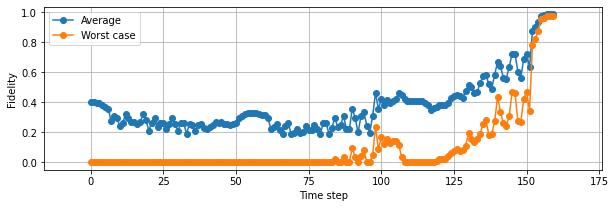

Max amp difference: 0.44


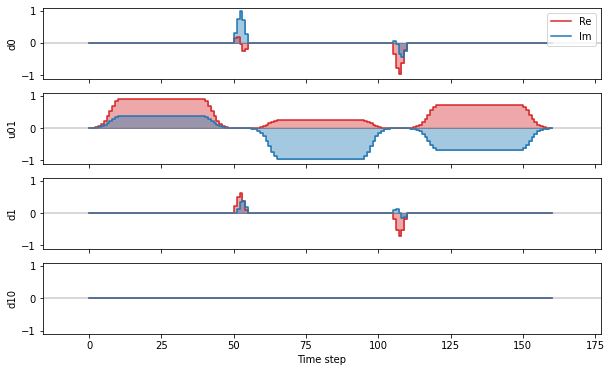

In [12]:
# Saved optimized angles
x_X90I = np.array([ 1.        ,  0.25705079, -0.46631134, -1.33888415])
x_IX90 = np.array([ 0.71479103,  0.24319973, -0.41055427, -0.11303429])
x_CNOT = np.array([ 0.45272866,  1.        ,  0.15123441, -0.15832501])
x_SWAP = np.array([ 0.40192683, 1.60814476 ,  0.50891225, -1.31562956, 
                   -2.81163055, -3.13722026, -0.74656652])

channel_labels = ['d0','u01','d1','d10']

drag_pulse_0 = DRAG(5, *x_X90I[:-1])
drag_pulse_1 = DRAG(5, *x_IX90[:-1])
GS_pulse = GaussianSquare(50, *x_CNOT[:-1])

cnot_pulse_1 = np.zeros([len(GS_pulse),8])
cnot_pulse_1[:,2:4] = Z_shift(GS_pulse,x_SWAP[0])

hh_pulse_1 = np.zeros([len(drag_pulse_0),8])
hh_pulse_1[:, :2] = Z_shift(drag_pulse_0,x_SWAP[1])
hh_pulse_1[:,4:6] = Z_shift(drag_pulse_1,x_SWAP[2])

cnot_pulse_2 = np.zeros([len(GS_pulse),8])
cnot_pulse_2[:,2:4] = Z_shift(GS_pulse,x_SWAP[3])

hh_pulse_2 = np.zeros([len(drag_pulse_0),8])
hh_pulse_2[:, :2] = Z_shift(drag_pulse_0,x_SWAP[4])
hh_pulse_2[:,4:6] = Z_shift(drag_pulse_1,x_SWAP[5])

cnot_pulse_3 = np.zeros([len(GS_pulse),8])
cnot_pulse_3[:,2:4] = Z_shift(GS_pulse,x_SWAP[6])

total_pulse = np.vstack([cnot_pulse_1,hh_pulse_1,
                         cnot_pulse_2,hh_pulse_2,cnot_pulse_3])

max_diff = abs(total_pulse[1:,:]-total_pulse[:-1,:]).max()

# run environment
env.step_params['reward_type'] = 'average'
env.reset()
avg_fids = []
states = []
for action in total_pulse:
    state,reward,done,_ = env.step(action)
    avg_fids.append(env.fid)
    states.append(state)
avg_fids = np.array(avg_fids)
states = np.array(states)

env.step_params['reward_type'] = 'worst'
env.reset()
worst_fids = []
for action in total_pulse:
    state,reward,done,_ = env.step(action)
    worst_fids.append(env.fid)
worst_fids = np.array(worst_fids)

print('-----------------------------------------------')
print('Final fidelities')
print(f'  Average: {avg_fids[-1]:.4f}')
print(f'  Worst  : {worst_fids[-1]:.4f}')
print(f'Max worst-case fidelity: {worst_fids.max():.4f} at step {worst_fids.argmax()+1}')

plt.figure(figsize=(10,3))
plt.plot(avg_fids,'o-',label='Average')
plt.plot(worst_fids,'o-',label='Worst case')
plt.xlim([-int(0.1*len(total_pulse)),len(total_pulse)+int(0.1*len(total_pulse))])
plt.xlabel('Time step')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.show()

print(f'Max amp difference: {max_diff:.2f}')
plot_pulse(total_pulse,channel_labels)

In [28]:
dFavg = avg_fids[1:]-avg_fids[:-1]
Favg = (avg_fids[1:]+avg_fids[:-1])/2

0.2218487496163564

In [24]:
env.avg_fid+dFavg.sum()

0.9885823077527688

In [25]:
NLI(avg_fids[-1])

1.9382059050891387

In [43]:
dNLI = dFavg/(1-Favg)/np.log(10)
# dNLI = dFavg/(1-avg_fids[:-1])/np.log(10)
NLI(env.avg_fid)+dNLI.sum()

1.8555099449465462

In [44]:
dNLI

array([-1.69305281e-04, -9.52777832e-04, -2.48852522e-03, -7.86667357e-03,
       -7.85925357e-03, -9.13594763e-03, -5.30975316e-02,  1.91252104e-02,
       -5.30229162e-03, -3.34422551e-02,  1.27255088e-02,  3.38557481e-02,
       -1.26934172e-02, -1.86572118e-02,  6.36151957e-04, -7.25551457e-03,
        5.41101703e-03,  3.49849644e-02, -2.36924284e-02, -4.29224279e-02,
        3.13535359e-02,  1.90782932e-02, -3.63264549e-02,  1.50473646e-02,
        5.10942652e-04, -2.40983681e-02,  2.17646735e-02,  2.27112861e-02,
       -2.53439668e-02, -2.40771428e-02,  2.79531505e-02, -6.67249033e-04,
       -3.89494635e-02,  3.71523790e-02, -4.17328936e-03, -2.36180813e-02,
        2.40643766e-02,  3.14508195e-03, -1.46900802e-02, -4.67639014e-03,
        9.48744120e-03,  7.76531901e-03,  8.28318065e-03, -9.70135058e-04,
        1.07611044e-03, -7.54750137e-03,  2.78544976e-03, -3.98426821e-03,
        2.52267786e-03,  5.04687295e-03,  1.89313539e-02,  6.36558763e-03,
        1.05894550e-02,  